In [119]:
import pandas as pd

In [120]:
# read built dataset
df = pd.read_csv('../../datasets/built_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475428 entries, 0 to 475427
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   item_name                  475428 non-null  object 
 1   category_name              475428 non-null  object 
 2   date                       475428 non-null  object 
 3   time                       475428 non-null  object 
 4   item_code                  475428 non-null  int64  
 5   quantity_sold_kg           475428 non-null  float64
 6   unit_selling_price_rmb/kg  475428 non-null  float64
 7   sale_or_return             475428 non-null  object 
 8   discount                   475428 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 32.6+ MB


In [121]:
# drop non-dependant columns
df = df.drop(columns=['item_code', 'discount'])
df.sample(2)

,item_name,category_name,date,time,quantity_sold_kg,unit_selling_price_rmb/kg,sale_or_return
50101,spinach,flower,2021-02-26,17:41:19.687,0.226,8.0,sale
381488,wuhu green pepper,capsicum,2022-08-06,20:49:51.123,0.354,4.0,sale


<Axes: >

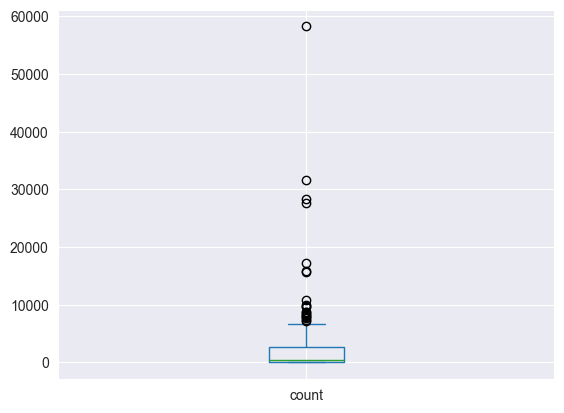

In [122]:
# visualise frequency of selling an item
df['item_name'].value_counts().plot.box()

In [123]:
"""according to the above boxplot there are some items that are sold more than 5000 times. 
    they can be considered as hot selling items and no need to predict a discount on them"""

# drop hot selling items
(df['item_name'].value_counts() > 2000).sum()

53

In [124]:
import numpy as np

In [125]:
# rename top selling items as 'Other'
filt = (df['item_name'].value_counts() > 2000)
df['item_name'] = np.where(filt[df['item_name'].values], 'Other', df['item_name'])
filt = df['item_name'] == 'Other'
df = df.loc[~filt]

df['item_name'].unique().shape[0]

124

<Axes: >

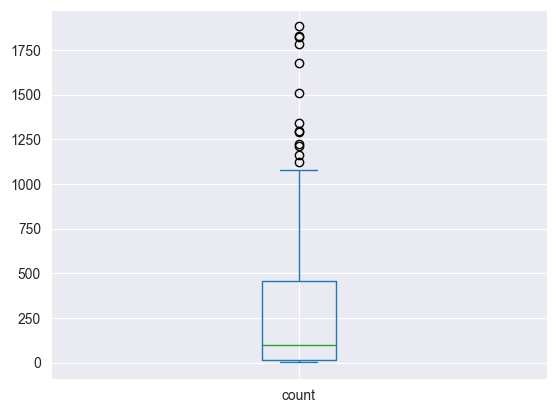

In [126]:
# visualise frequency of selling for rest of items
df['item_name'].value_counts().plot.box()

<Axes: >

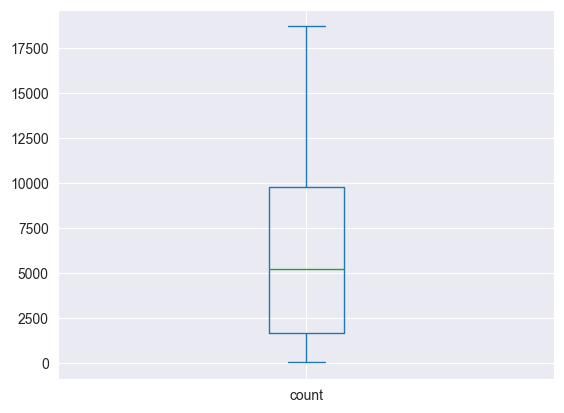

In [127]:
# visualise frequency of selling an category
df['category_name'].value_counts().plot.box()

In [128]:
# check wheather (-) values of sold amount are returned items
(df['quantity_sold_kg'] < 0).sum() == (df['sale_or_return'] == 'return').sum()

True

In [129]:
# remove returned item records
filt = (df['sale_or_return'] == 'return')
df = df.loc[~filt]

df = df.drop(columns=['sale_or_return'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40936 entries, 10 to 475427
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_name                  40936 non-null  object 
 1   category_name              40936 non-null  object 
 2   date                       40936 non-null  object 
 3   time                       40936 non-null  object 
 4   quantity_sold_kg           40936 non-null  float64
 5   unit_selling_price_rmb/kg  40936 non-null  float64
dtypes: float64(2), object(4)
memory usage: 2.2+ MB


In [130]:
# check if there are 0 sold amounts
(df['quantity_sold_kg'] == 0).sum()

0

<Axes: >

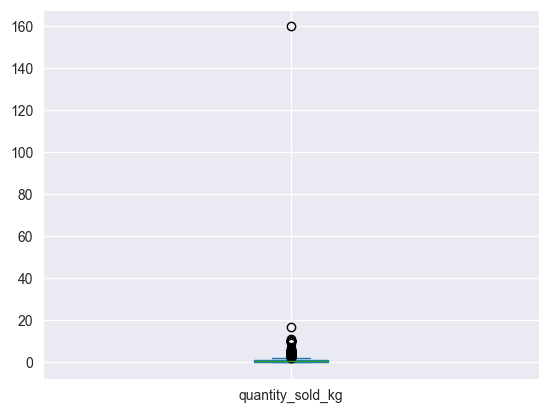

In [131]:
# visualise sold amount
df['quantity_sold_kg'].plot.box()

In [132]:
# check the mean of sold amount
np.mean(df['quantity_sold_kg'])

0.6290846443228453

In [133]:
"""according to the above boxplot there are only few purchases that are sold more than 12.5 kg. in general 12.5 kg is very uncommon to buy in a single time and can consider them as outliers. so handle them with mean values."""

# handle outlier with mean values
filt = df['quantity_sold_kg'] > 120
df = df[~filt]

# check the change of mean
np.mean(df['quantity_sold_kg']), df['quantity_sold_kg'].max()

(0.625191376572615, 17.0)

<Axes: >

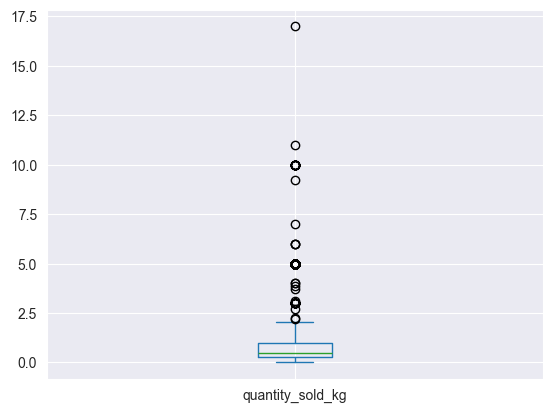

In [134]:
# visualise sold amount
df['quantity_sold_kg'].plot.box()

<Axes: >

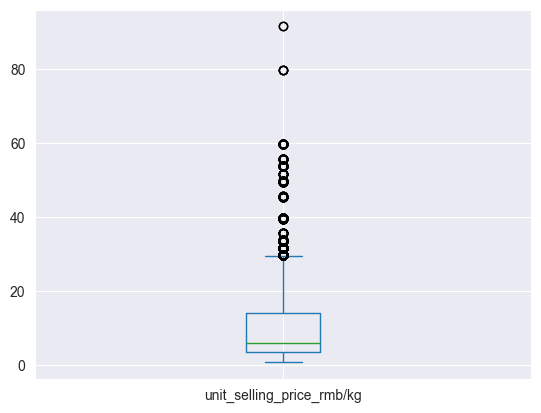

In [135]:
# visualise price
df['unit_selling_price_rmb/kg'].plot.box()

In [136]:
df['time'] = df['time'].str.split(':').str[0].astype(int)

In [137]:
df['time'].head(3)

10     9
35     9
77    10
Name: time, dtype: int64

In [138]:
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day
df = df.drop(columns=['date', 'time'])
df.head(3)

,item_name,category_name,quantity_sold_kg,unit_selling_price_rmb/kg,month,day
10,jigu mushroom,mushroom,0.250,16.0,1,1
35,bell pepper,capsicum,0.313,16.0,1,1
77,fresh black fungus,mushroom,0.243,14.0,1,1


In [139]:
"""according to the above boxplot there are some items that are sold more than 50 rmb/kg. 
    they can be considered as rare items and by selling very less amount of them aslo can be considered as hot selling. so it is better to not to predict a discount on them"""

price = df[['month', 'day', 'item_name', 'category_name', 'unit_selling_price_rmb/kg']]
df = df.drop(columns=['unit_selling_price_rmb/kg'])
price = price.groupby(['month', 'day', 'item_name', 'category_name']).mean().reset_index()

# group dataset by item name, category and date
df = df.groupby(['month', 'day', 'item_name', 'category_name']).sum().reset_index()
df.shape, price.shape

((6054, 5), (6054, 5))

In [140]:
df = df.merge(price, on=['month', 'day', 'item_name', 'category_name'], how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      6054 non-null   int32  
 1   day                        6054 non-null   int32  
 2   item_name                  6054 non-null   object 
 3   category_name              6054 non-null   object 
 4   quantity_sold_kg           6054 non-null   float64
 5   unit_selling_price_rmb/kg  6054 non-null   float64
dtypes: float64(2), int32(2), object(2)
memory usage: 236.6+ KB


In [141]:
df.head(3)

,month,day,item_name,category_name,quantity_sold_kg,unit_selling_price_rmb/kg
0,1,1,7 colour pepper,capsicum,3.071,18.0
1,1,1,bell pepper,capsicum,0.520,16.0
2,1,1,caidian quinoa artemisia,flower,0.585,19.8


<Axes: >

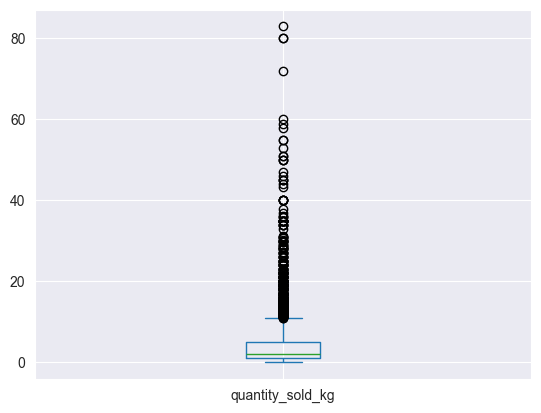

In [142]:
# visualise processed sold amount
df['quantity_sold_kg'].plot.box()

<Axes: >

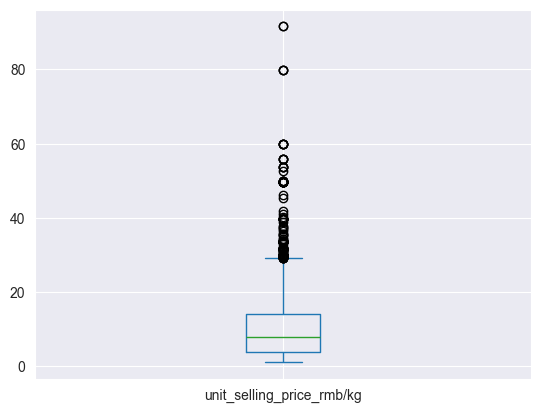

In [143]:
# visualise unit selling price
df['unit_selling_price_rmb/kg'].plot.box()

In [144]:
# view co-relation between price and sold amount
df.loc[:,['unit_selling_price_rmb/kg', 'quantity_sold_kg']].corr()

,unit_selling_price_rmb/kg,quantity_sold_kg
unit_selling_price_rmb/kg,1.000000,-0.304224
quantity_sold_kg,-0.304224,1.000000


<Axes: xlabel='unit_selling_price_rmb/kg', ylabel='quantity_sold_kg'>

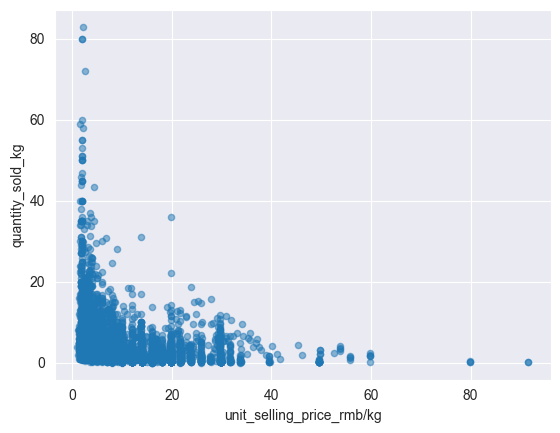

In [145]:
# visualise relation between price and sold amount
df.plot.scatter(x = 'unit_selling_price_rmb/kg', y = 'quantity_sold_kg', alpha = 0.5)

In [146]:
df['item_name'].unique().shape[0]

124

In [147]:
# one hot encoding
df = pd.get_dummies(df)
df.shape

(6054, 134)

In [148]:
df.sample(3)

,month,day,quantity_sold_kg,unit_selling_price_rmb/kg,item_name_7 colour pepper,item_name_agaricus bisporus,item_name_aihao,item_name_amaranth,item_name_basil,item_name_bell pepper,...,item_name_yuxingcao,item_name_zhijiang red bolt,item_name_zhimaxiancai,item_name_zhuyecai,category_name_aquatic,category_name_cabbage,category_name_capsicum,category_name_flower,category_name_mushroom,category_name_solanum
1237,3,19,0.222,19.800000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1152,3,16,0.995,12.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1930,4,19,3.122,5.777778,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [149]:
# save pre-processed dataset
df.to_csv('pre_processed_dataset.csv', index=False)